In [71]:
import os,sys
import xlrd
import math
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn import metrics as mt
import seaborn as sns
import datetime
import time
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc
import pylab as p
from sklearn import tree
from io import BytesIO as StringIO
from IPython.display import Image
import pydotplus

In [7]:
email_table = pd.read_csv("/Users/Student/Desktop/email/email_table.csv")
print ("email_table shape : ", email_table.shape)

email_opened_table = pd.read_csv("/Users/Student/Desktop/email/email_opened_table.csv")
print ("email_opened_table.shape : ", email_opened_table.shape)

link_clicked_table = pd.read_csv("/Users/Student/Desktop/email/link_clicked_table.csv")
print ("link_clicked_table.shape : ", link_clicked_table.shape)

email_table shape :  (100000, 7)
email_opened_table.shape :  (10345, 1)
link_clicked_table.shape :  (2119, 1)


In [9]:
#Let's create one data set # are there dupes?
print (len(email_table['email_id'].unique()) == len(email_table['email_id']))
print (len(email_opened_table['email_id'].unique()) == len(email_opened_table['email_id']))
print (len(link_clicked_table['email_id'].unique()) == len(link_clicked_table['email_id']))

True
True
True


In [10]:
email_opened_table['email_opened']=1
link_clicked_table['link_clicked']=1

In [11]:
dataframe = email_table.merge(email_opened_table, how='left', on='email_id')  #this way we don't lose data
dataframe = dataframe.merge(link_clicked_table, how='left', on='email_id')  #this way we don't lose data

In [13]:
dataframe.dtypes

email_id                 int64
email_text              object
email_version           object
hour                     int64
weekday                 object
user_country            object
user_past_purchases      int64
email_opened           float64
link_clicked           float64
dtype: object

In [14]:
dataframe.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_opened,link_clicked
0,85120,short_email,personalized,2,Sunday,US,5,NaN,NaN
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,NaN,NaN
3,493711,short_email,generic,6,Monday,UK,1,NaN,NaN
4,106887,long_email,generic,14,Monday,US,6,NaN,NaN


In [15]:
dataframe = dataframe.fillna({
    'email_opened': 0,
    'link_clicked': 0})

In [16]:
dataframe['sum_check']=dataframe['email_opened']+dataframe['link_clicked']

In [20]:
def test_robust_merge (df_col, sum_value):    
    for i in xrange(len(df_col)):
        if df_col.iloc[i] ==1:
            if dataframe['sum_check'].iloc[i] <sum_value:
                print ("Error in row", i)
                return False
    return True

In [25]:
print (test_robust_merge (dataframe['email_opened'],1))
print (test_robust_merge (dataframe['link_clicked'],2))

NameError: name 'xrange' is not defined

In [26]:
dataframe.iloc[3156]

email_id                   104883
email_text             long_email
email_version             generic
hour                           14
weekday                    Friday
user_country                   US
user_past_purchases             7
email_opened                    0
link_clicked                    1
sum_check                       1
Name: 3156, dtype: object

In [27]:
dataframe = dataframe[dataframe['email_id']!=104883]

In [32]:
def examine_data_frame( df):
    for name in df.columns:
        print ("----------")
        print (df[ name].dtype)
        if df[ name].dtype is np.dtype( 'O'):
            print (df[ name].value_counts())
            print ("Name: ", name)
        else:
            print (df[ name].describe())

In [33]:
examine_data_frame(dataframe)

----------
int64
count     99999.000000
mean     498694.134271
std      289229.492658
min           8.000000
25%      246726.000000
50%      498452.000000
75%      749943.500000
max      999998.000000
Name: email_id, dtype: float64
----------
object
long_email     50275
short_email    49724
Name: email_text, dtype: int64
Name:  email_text
----------
object
generic         50208
personalized    49791
Name: email_version, dtype: int64
Name:  email_version
----------
int64
count    99999.000000
mean         9.059251
std          4.439632
min          1.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         24.000000
Name: hour, dtype: float64
----------
object
Saturday     14569
Sunday       14387
Monday       14363
Thursday     14277
Friday       14176
Tuesday      14143
Wednesday    14084
Name: weekday, dtype: int64
Name:  weekday
----------
object
US    60098
UK    19939
FR     9995
ES     9967
Name: user_country, dtype: int64
Name:  user_country
---------

In [35]:
print ((len(email_opened_table)/float(100000))*100) # % of user opened emails

10.345


In [36]:
print ((len(link_clicked_table)/float(len(email_opened_table)))*100) # % of user opened emails

20.483325277912034


Printing email opened & links clicked by country
              email_opened  link_clicked
user_country                            
ES                0.039129      0.008327
FR                0.040620      0.008004
UK                0.120167      0.024675
US                0.119022      0.024344


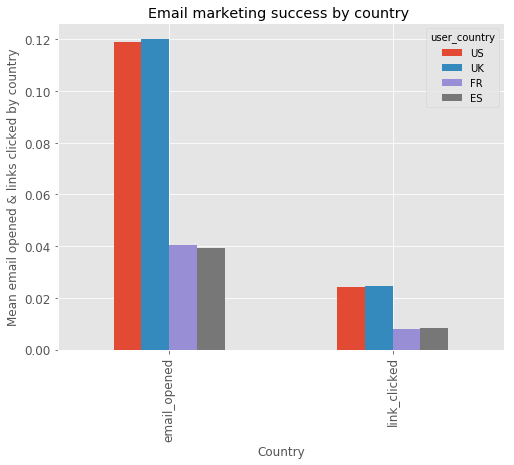

In [38]:
df = dataframe[['email_opened','link_clicked', 'user_country']]
df_grpmean=df.groupby('user_country').mean()
print ("Printing email opened & links clicked by country")
print
print (df_grpmean)
transposed_df = df_grpmean.transpose()
print
import matplotlib.pyplot as plt
ax = transposed_df[['US','UK','FR','ES']].plot(kind='bar', title ="Email marketing success by country ", figsize=(8, 6), legend=True, fontsize=12)
ax.set_xlabel("Country", fontsize=12)
ax.set_ylabel("Mean email opened & links clicked by country", fontsize=12)
plt.show()

Printing email opened & links clicked by weekday
           email_opened  link_clicked
weekday                              
Friday         0.074139      0.013967
Monday         0.116062      0.022906
Saturday       0.087652      0.017846
Sunday         0.087649      0.016751
Thursday       0.118442      0.024445
Tuesday        0.120484      0.024889
Wednesday      0.120278      0.027620


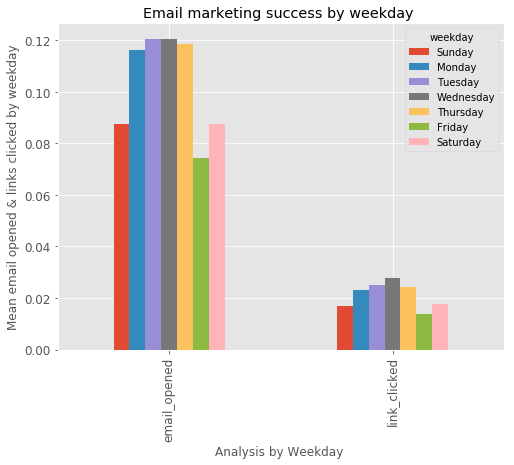

In [39]:
df = dataframe[['email_opened','link_clicked', 'weekday']]
df_grpmean=df.groupby('weekday').mean()
print ("Printing email opened & links clicked by weekday")
print
print (df_grpmean)
transposed_df = df_grpmean.transpose()
print
import matplotlib.pyplot as plt
ax = transposed_df[['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']].plot(kind='bar', title ="Email marketing success by weekday ", figsize=(8, 6), legend=True, fontsize=12)
ax.set_xlabel("Analysis by Weekday ", fontsize=12)
ax.set_ylabel("Mean email opened & links clicked by weekday", fontsize=12)
plt.show()

Text(0.5,0,'Hour of the day')

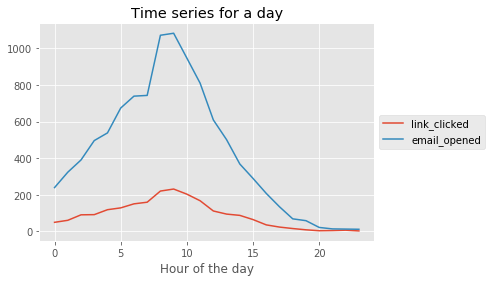

In [40]:
df3 = dataframe[(dataframe['link_clicked'] ==1)]
y3,binEdges=np.histogram(df3[ "hour"], bins =24)
p.plot(y3,'-',label='link_clicked')
p.legend(loc='center left', bbox_to_anchor=(1, 0.5))
p.title("Time series for a day")
p.xlabel("Hour of the day")


df3 = dataframe[(dataframe['email_opened'] ==1)]
y3,binEdges=np.histogram(df3[ "hour"], bins =24)
p.plot(y3,'-',label='email_opened')
p.legend(loc='center left', bbox_to_anchor=(1, 0.5))
p.title("Time series for a day")
p.xlabel("Hour of the day")

In [41]:
def numeric_week(x):
    if x == 'Sunday':
        return 0
    elif x == 'Monday':
        return 24
    elif x=='Tuesday':
        return 48
    elif x=='Wednesday':
        return 72
    elif x == 'Thursday':
        return 96
    elif x == 'Friday':
        return 120
    else:
        return 144

In [42]:
dataframe['numeric_week'] = dataframe['weekday'].map(numeric_week) # Keep education column for EDA

In [43]:
dataframe['hour_of_week'] = (dataframe['hour'] +dataframe['numeric_week'])

Text(0.5,0,'Hour of the week (Total 168)')

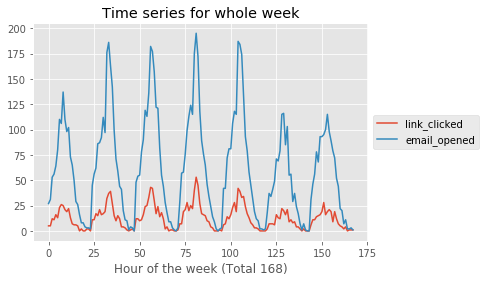

In [44]:
df3 = dataframe[(dataframe['link_clicked'] ==1)]
y3,binEdges=np.histogram(df3[ "hour_of_week"], bins =168)
p.plot(y3,'-',label='link_clicked')
p.legend(loc='center left', bbox_to_anchor=(1, 0.5))
p.title("Time series for whole week")
p.xlabel("Hour of the week (Total 168)")


df3 = dataframe[(dataframe['email_opened'] ==1)]
y3,binEdges=np.histogram(df3[ "hour_of_week"], bins =168)
p.plot(y3,'-',label='email_opened')
p.legend(loc='center left', bbox_to_anchor=(1, 0.5))
p.title("Time series for whole week")
p.xlabel("Hour of the week (Total 168)")

In [46]:
grouped = dataframe.groupby( "email_opened")
email_opened = grouped[ "user_past_purchases"].describe()
email_opened = email_opened.unstack( level=-1)
print (email_opened)

       email_opened
count  0.0             89654.000000
       1.0             10345.000000
mean   0.0                 3.785118
       1.0                 4.686999
std    0.0                 3.169900
       1.0                 3.306502
min    0.0                 0.000000
       1.0                 0.000000
25%    0.0                 1.000000
       1.0                 2.000000
50%    0.0                 3.000000
       1.0                 4.000000
75%    0.0                 6.000000
       1.0                 7.000000
max    0.0                21.000000
       1.0                22.000000
dtype: float64


In [49]:
grouped  ==  dataframe.groupby( "link_clicked")
link_clicked = grouped[ "user_past_purchases"].describe()
link_clicked = link_clicked.unstack( level=-1)
print (link_clicked)

       email_opened
count  0.0             89654.000000
       1.0             10345.000000
mean   0.0                 3.785118
       1.0                 4.686999
std    0.0                 3.169900
       1.0                 3.306502
min    0.0                 0.000000
       1.0                 0.000000
25%    0.0                 1.000000
       1.0                 2.000000
50%    0.0                 3.000000
       1.0                 4.000000
75%    0.0                 6.000000
       1.0                 7.000000
max    0.0                21.000000
       1.0                22.000000
dtype: float64


In [50]:
cols =['email_text', 'email_version', 'user_country','weekday']
data_1 = dataframe[cols]
data_dummies = pd.get_dummies(data_1)
result_df = pd.concat([data_dummies, dataframe], axis=1)
result_df.head()

,email_text_long_email,email_text_short_email,email_version_generic,email_version_personalized,user_country_ES,user_country_FR,user_country_UK,user_country_US,weekday_Friday,weekday_Monday,...,email_version,hour,weekday,user_country,user_past_purchases,email_opened,link_clicked,sum_check,numeric_week,hour_of_week
0,0,1,0,1,0,0,0,1,0,0,...,personalized,2,Sunday,US,5,0.0,0.0,0.0,0,2
1,1,0,0,1,0,0,1,0,0,0,...,personalized,12,Sunday,UK,2,1.0,1.0,2.0,0,12
2,1,0,0,1,0,0,0,1,0,0,...,personalized,11,Wednesday,US,2,0.0,0.0,0.0,72,83
3,0,1,1,0,0,0,1,0,0,1,...,generic,6,Monday,UK,1,0.0,0.0,0.0,24,30
4,1,0,1,0,0,0,0,1,0,1,...,generic,14,Monday,US,6,0.0,0.0,0.0,24,38


/Users/Student/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Student/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Student/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Most important features..
email_text_long_email has weight of -0.14336712897365048
email_version_personalized has weight of 0.27631534964354176
user_country_ES has weight of -0.25792060862560867
user_country_FR has weight of -0.2526323333075984
user_country_UK has weight of 0.15912543696831052
user_country_US has weight of 0.18280554310131142
weekday_Friday has weight of -0.12780918692430995
weekday_Monday has weight of 0.0477364155664934
weekday_Saturday has weight of -0.05294399575593619
weekday_Sunday has weight of -0.06267786533916116
weekday_Thursday has weight of 0.05949294536403332
weekday_Tuesday has weight of 0.06582242557587609
weekday_Wednesday has weight of 0.07108167023783868
hour has weight of 0.10255899709826759
user_past_purchases has weight of 0.2921944955409709
accuracy: 0.5891
Confusion matrix : 
[[5205 3737]
 [ 372  686]]
ROC AUC: 0.61


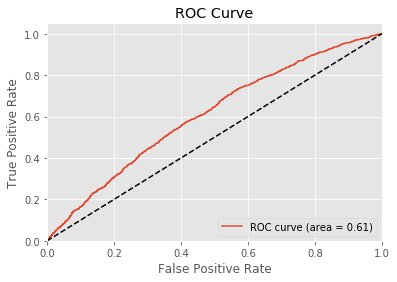

Classification Report..
             precision    recall  f1-score   support

        0.0       0.93      0.58      0.72      8942
        1.0       0.16      0.65      0.25      1058

avg / total       0.85      0.59      0.67     10000

Plot of most important features...


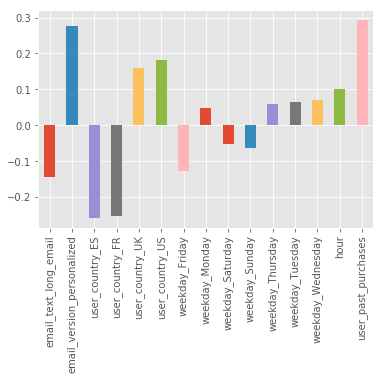

In [56]:
result_df2 = result_df[['email_text_long_email',
       'email_version_personalized',
       'user_country_ES', 'user_country_FR', 'user_country_UK',
       'user_country_US', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'hour','user_past_purchases','email_opened']]
y = result_df2['email_opened'].values
X = result_df2[['email_text_long_email',
       'email_version_personalized',
       'user_country_ES', 'user_country_FR', 'user_country_UK',
       'user_country_US', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'hour','user_past_purchases']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

lr_clf = LogisticRegression(penalty='l2', C=0.05, class_weight="balanced") # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,result_df2.columns) # combine attributes
#zip_vars.sort(key = lambda t: np.abs(t[0]), reverse=True) # sort them by the magnitude of the weight
print ("Most important features..")
for coef, name in zip_vars:
    print (name, 'has weight of', coef[0]) # now print them out
print    
# Determine the false positive and true positive rates
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print ('accuracy:', acc) 
print ("Confusion matrix : ")
print (conf)
print 

fpr, tpr, _ = roc_curve(y_test, lr_clf.predict_proba(X_test)[:,1])

# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print
print ("Classification Report..")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

print ("Plot of most important features...")
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0], index = ['email_text_long_email',
       'email_version_personalized',
       'user_country_ES', 'user_country_FR', 'user_country_UK',
       'user_country_US', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'hour','user_past_purchases'])
weights.plot(kind='bar')
plt.show()

/Users/Student/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Student/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Student/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Most important features..
email_text_long_email has weight of -0.13691576719627213
email_version_personalized has weight of 0.3239342939077502
user_country_ES has weight of -0.25095906353313785
user_country_FR has weight of -0.24239352927550722
user_country_UK has weight of 0.1641383458304061
user_country_US has weight of 0.16841346814508876
weekday_Friday has weight of -0.14324303256828644
weekday_Monday has weight of 0.04367398562611597
weekday_Saturday has weight of -0.05676858352250705
weekday_Sunday has weight of -0.07240877504022758
weekday_Thursday has weight of 0.062317502660079176
weekday_Tuesday has weight of 0.06124796967553959
weekday_Wednesday has weight of 0.10601382897469042
hour has weight of 0.08257629981456431
user_past_purchases has weight of 0.674305364409906
accuracy: 0.6803
Confusion matrix : 
[[6670 3127]
 [  70  133]]
ROC AUC: 0.71


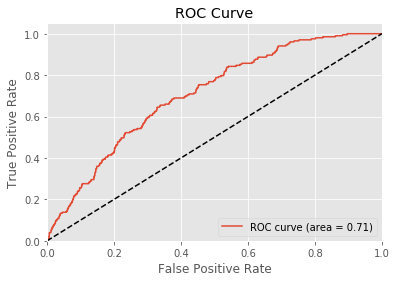

Classification Report..
             precision    recall  f1-score   support

        0.0       0.99      0.68      0.81      9797
        1.0       0.04      0.66      0.08       203

avg / total       0.97      0.68      0.79     10000

Plot of most important features...


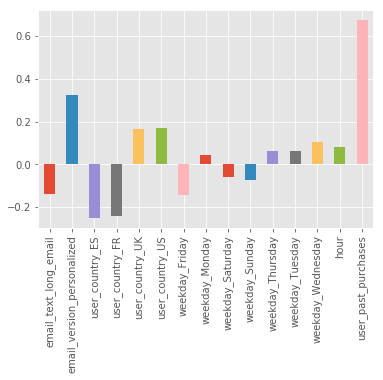

In [61]:
result_df2 = result_df[['email_text_long_email',
       'email_version_personalized',
       'user_country_ES', 'user_country_FR', 'user_country_UK',
       'user_country_US', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'hour','user_past_purchases','link_clicked']]
y = result_df2['link_clicked'].values
X = result_df2[['email_text_long_email',
       'email_version_personalized',
       'user_country_ES', 'user_country_FR', 'user_country_UK',
       'user_country_US', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'hour','user_past_purchases']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

lr_clf = LogisticRegression(penalty='l2', C=0.05, class_weight="balanced") # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,result_df2.columns) # combine attributes
#zip_vars.sort(key = lambda t: np.abs(t[0]), reverse=True) # sort them by the magnitude of the weight
print ("Most important features..")
for coef, name in zip_vars:
    print (name, 'has weight of', coef[0]) # now print them out
print    
# Determine the false positive and true positive rates
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print ('accuracy:', acc) 
print ("Confusion matrix : ")
print (conf)
print 

fpr, tpr, _ = roc_curve(y_test, lr_clf.predict_proba(X_test)[:,1])

# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print
print ("Classification Report..")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

print ("Plot of most important features...")
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0], index = ['email_text_long_email',
       'email_version_personalized',
       'user_country_ES', 'user_country_FR', 'user_country_UK',
       'user_country_US', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'hour','user_past_purchases'])
weights.plot(kind='bar')
plt.show()

In [62]:
result_df['past_purchases>=6'] = result_df['user_past_purchases'].apply(lambda x: 1 if x >=6 else 0)

In [64]:
len(result_df)
print (result_df['past_purchases>=6'].sum()) # total number of user out of 100,000

27473


In [65]:
test_df = result_df[result_df['past_purchases>=6']==1]

In [67]:
test_df2 = result_df[result_df['past_purchases>=6']==0]
print ((test_df2['link_clicked'].sum())/float(len(test_df2))*100) # % of users clicked link with past purchases <5.5

1.3677853459449025


In [68]:
print ((test_df['link_clicked'].sum())/float(len(test_df))*100) # % of users clicked link with past purchases >=5.5

4.09856950460452


In [69]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

X = result_df[['email_text_long_email',
       'email_version_personalized',
       'user_country_ES', 'user_country_FR', 'user_country_UK',
       'user_country_US', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'hour','user_past_purchases','link_clicked','email_opened']]
y = result_df['past_purchases>=6']

print('Original dataset shape {}'.format(Counter(y)))
sm = SMOTE(kind = 'regular')
X_res, y_res = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

ModuleNotFoundError: No module named 'imblearn'